# causalnex Trial 02

sklearnrライクなmethodを用いた因果グラフ推定。Lasso, pytorchを用いたNOTEARSの因果グラフ推定。

- DAGClassifier, DAGRegressor
- from_pandas_lasso, from_pandas(pytorch)

In [1]:
!ls

sample_data


In [2]:
!git clone https://github.com/HisakaKoji/blog.git

Cloning into 'blog'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 51 (delta 19), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (51/51), done.


In [3]:
%cd blog

/content/blog


In [4]:
%cd notebooks

/content/blog/notebooks


# 必要パッケージ インストール & import

In [5]:
!pip install causalnex
!pip install networkx
!pip install pgmpy
from IPython.display import clear_output
clear_output()

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx
import warnings; warnings.simplefilter("ignore")
%matplotlib inline

In [7]:
import causalnex
from causalnex.structure.notears import from_pandas , from_pandas_lasso
from causalnex.structure.pytorch import from_pandas as from_pandas_pytorch

from causalnex.structure import DAGClassifier, DAGRegressor

In [8]:
# networkx_util
from util.networkx_util import NetworkxUtil
nx_util = NetworkxUtil() # networkxの図示, printのためのutil

# サンプルデータ

In [9]:
def generate_sample_data(n_samples=1000):
    """
    サンプルデータ生成
    | c1 --> x1
    | c2 --> x1
    | c1 --> y
    | c2 --> y
    | x1 --> y
    | x2 は独立
    """
    np.random.seed(0)
    c1 = np.random.normal(0, 0.5, size=n_samples)
    c2 = np.random.choice(2, size=n_samples)

    np.random.seed(1)
    x1 = np.random.normal(1, 2, size=n_samples) + c1 + c2/10

    np.random.seed(2)
    y = np.random.uniform(-1,2, size=n_samples) + x1 + c1 + c2 /10

    np.random.seed(3)
    x2 = np.random.uniform(-2, 2, size=n_samples)
    raw_data = pd.DataFrame({"x1": x1, "y":y, "x2": x2, "c1": c1, "c2":c2})
    return raw_data

In [10]:
n_samples = 2000
struct_data = generate_sample_data(n_samples)

X = struct_data.drop(["y"], axis=1)
y = struct_data["y"]
print(X.shape)

(2000, 4)


# NOTEARSをsklearn interfaceのmethodで実行

## DAGRegressor

In [11]:
dist_type_schema = {
    "x1" : "cont",
    "x2" : "cont",
    "c1" : "cont",
    "c2" : "bin",
    "y" : "cont"
}

In [12]:
reg = DAGRegressor(
    threshold= 0.08,  # edge weightの閾値
    dist_type_schema = dist_type_schema,#  dist_typeを指定することも可能
    alpha = 0., # L1
    beta = 0., # L2 
    hidden_layer_units = None,
    standardize=False,
    enforce_dag=True,
    tabu_edges=None,
    tabu_parent_nodes=None,
    tabu_child_nodes=None,
    dependent_target = True # yは親ノードにならない制約
)

In [13]:
# sklearnライクでfit, predict
reg.fit(X, y)
y_pred = reg.predict(X)
print(y_pred)

[ 6.62433052  0.81901956  1.386024   ... -0.0155662   1.82587767
  2.93284583]


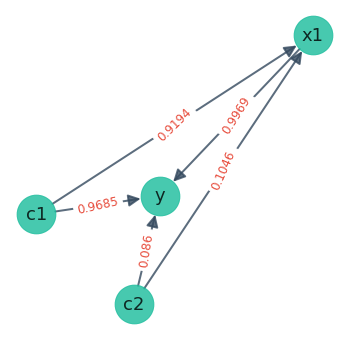

In [14]:
# plot structure model
sm = reg.graph_
sm = sm.get_largest_subgraph()
nx_util.plot_structure_model(sm, layout_method="random", figsize=(6,6), layout_seed=1)

In [15]:
# weightをprint
nx_util.print_weights(sm)

[ x1 ] ---> [ y ]		Weight	0.99692
[ c1 ] ---> [ x1 ]		Weight	0.91944
[ c1 ] ---> [ y ]		Weight	0.96849
[ c2 ] ---> [ x1 ]		Weight	0.10456
[ c2 ] ---> [ y ]		Weight	0.08597


## DAGClassifier

In [16]:
# 2値分類タスクに変換
y = y > np.median(y)
y = y.astype(int)

In [17]:
clf = DAGClassifier(
    threshold= 0.1, # edge weightの閾値
    #dist_type_schema = dist_type_schema,
    alpha = 0.0, # L1
    beta = 0.0,
    hidden_layer_units =None,
    standardize=False,
    enforce_dag=True,
    tabu_edges=None,
    tabu_parent_nodes=["y"],
    tabu_child_nodes=None,
    dependent_target = True # yは親ノードにならない制約
)

In [18]:
clf.fit(X, y)
y_pred = clf.predict(X)
y_pred_proba = clf.predict_proba(X)

In [19]:
print("Pred Label: " ,y_pred[:5])
print("Pred Proba :",y_pred_proba[:5])

Pred Label:  [1 0 0 1 1]
Pred Proba : [[5.41210175e-05 9.99945879e-01]
 [8.21812585e-01 1.78187415e-01]
 [5.93134105e-01 4.06865895e-01]
 [4.42539692e-01 5.57460308e-01]
 [1.29222870e-03 9.98707771e-01]]


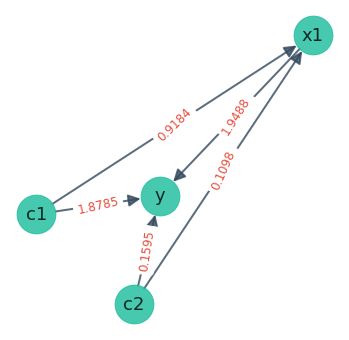

In [20]:
# plot structure model
sm = clf.graph_
sm = sm.get_largest_subgraph()
nx_util.plot_structure_model(sm, layout_method="random", figsize=(6,6))

## DAGClassifier  with hidden_layer_units

In [21]:
dist_type_schema = {
    "x1" : "cont",
    "x2" : "cont",
    "c1" : "cont",
    "c2" : "bin",
    "y" : "bin"
}

In [22]:
clf = DAGClassifier(
    threshold= 1.5, # この値以下の係数のedgeは削除
    dist_type_schema = dist_type_schema,
    alpha = 0.0, # L1
    beta = 0.0,
    hidden_layer_units =[5],
    standardize=False,
    enforce_dag=True,
    tabu_edges=None,
    tabu_parent_nodes=None,
    tabu_child_nodes=None,
    dependent_target = True # # yは親ノードにならない制約
)

In [23]:
clf.fit(X, y)
y_pred = clf.predict(X)
y_pred_proba = clf.predict_proba(X)

In [24]:
print("Pred Label" ,y_pred)
print("Pred Proba ",y_pred_proba)

Pred Label [1 0 1 ... 0 1 1]
Pred Proba  [[2.26497650e-06 9.99997735e-01]
 [8.06058079e-01 1.93941921e-01]
 [4.83405530e-01 5.16594470e-01]
 ...
 [9.94990386e-01 5.00961393e-03]
 [2.56293058e-01 7.43706942e-01]
 [5.23946881e-02 9.47605312e-01]]


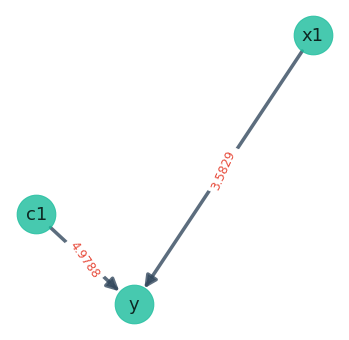

In [25]:
# plot structure model
sm = clf.graph_
sm = sm.get_largest_subgraph()
nx_util.plot_structure_model(sm, layout_method="random", figsize=(6,6))

# from_pandas_lasso, from_pandas(pytorch)実行

## L1 Penalty付きNO TEARSで因果グラフ推定

In [26]:
# NOTEARSを実行, from_pandas_lassoでL1 penaltyをつけて推定することが可能
sm = from_pandas_lasso( 
    struct_data,
    beta = 0.15,  # L1 penalty
    tabu_edges = [],
    tabu_parent_nodes = None,
    tabu_child_nodes = None,
)
sm.threshold_till_dag() # DAGになるように閾値をあげる
#sm.remove_edges_below_threshold(0.2) # 

[ x1 ] ---> [ y ]		Weight	1.08730
[ c1 ] ---> [ x1 ]		Weight	0.29201
[ c1 ] ---> [ y ]		Weight	0.24506
[ c2 ] ---> [ x1 ]		Weight	0.73727
[ c2 ] ---> [ y ]		Weight	0.14375


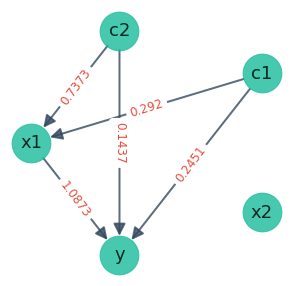

In [27]:
# weights print
nx_util.print_weights(sm)

# plot sturecture model
nx_util.plot_structure_model(sm, layout_method="shell", layout_seed=1, figsize=(5,5))

## pytorchでNO TEARSで因果グラフ推定

In [28]:
dist_type_schema = {
    "x1" : "cont",
    "x2" : "cont",
    "c1" : "cont",
    "c2" : "bin",
    "y" : "cont"
}

In [29]:
# data typeを加味してpytorchを用いて推定
sm_pytorch = from_pandas_pytorch(
    struct_data, 
    dist_type_schema = dist_type_schema, 
    lasso_beta = 0,  # L1
    ridge_beta = 0 , # L2
    w_threshold = 0.,  # edge_weight閾値
    use_bias = False
)
sm_pytorch.threshold_till_dag()
sm_pytorch.remove_edges_below_threshold(0.1) # 

[ x1 ] ---> [ y ]		Weight	1.02877
[ c1 ] ---> [ x1 ]		Weight	0.86269
[ c1 ] ---> [ y ]		Weight	0.95167
[ c2 ] ---> [ x1 ]		Weight	1.02574
[ c2 ] ---> [ y ]		Weight	0.51996


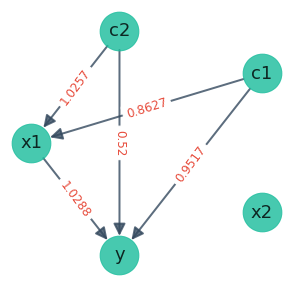

In [30]:
# weights print
nx_util.print_weights(sm_pytorch)

# plot sturecture model
nx_util.plot_structure_model(sm_pytorch, layout_method="shell", figsize=(5,5))